# Test of class Hamiltonian_QED

This notebook uses the class in 'Hamiltonian_QED.py' that builds the Hamiltonian in terms of Pauli matrices.

The code import the class in 'HC_Lattice.py' (that defines the lattice) and then is uses the Gray encoding for gauge fields (E and U) and Jordan-Wigner formulation for fermionic degrees of freedom.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from scipy.sparse.linalg import eigsh
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../") # go to parent dir

In [3]:
from Hamiltonian_QED import HamiltonianQED
from HC_Lattice import HCLattice

In [4]:
#class input parameters:
n_sites = [2,2,]#how many sites for every dimension
g=1
fact_e_op = 1
fact_b_op = 1
m=7
omega=1
l=1
L=1
lambd = 1000
magnetic_basis=False
pbc=False
puregauge = False #TODO check when true
static_charges_values =None#{(0,0):-1,(1,0):1}
display_hamiltonian=True
e_op_out_plus=False #if E out of site n has plus sign 
tn_comparison = False #TODO only kept for TN comparison, remove later

#exact diagonalisation parameters:
threshold = 1e-12
num_eigs = 5

In [5]:
latt = HCLattice(n_sites,pbc=pbc)

In [6]:
class_H = HamiltonianQED(
                        latt,
                        n_sites,
                        l,
                        ll=L,
                        magnetic_basis=magnetic_basis,
                        pbc=pbc,
                        puregauge=puregauge,
                        static_charges_values=static_charges_values,
                        e_op_out_plus = e_op_out_plus,
                        display_hamiltonian=display_hamiltonian,
                        tn_comparison=tn_comparison)

HamiltonianQED: Initializing...
>> Gauss law system of equations (symbolic + latex):


Eq(-E_00x - E_00y - q_00, 0)

Eq(E_00y - E_01x - q_01, 0)

Eq(E_00x - E_10y - q_10, 0)

Eq(E_01x + E_10y - q_11, 0)

Eq(q_00 + q_01 + q_10 + q_11, 0)

- E_{00x} - E_{00y} - q_{00} &= 0 \\ \nonumber
E_{00y} - E_{01x} - q_{01} &= 0 \\ \nonumber
E_{00x} - E_{10y} - q_{10} &= 0 \\ \nonumber
E_{01x} + E_{10y} - q_{11} &= 0 \\ \nonumber
q_{00} + q_{01} + q_{10} + q_{11} &= 0 

>> Hamiltonian (symbolic + latex):


Eq(H_E, g**2*(E_10y**2 + (-E_10y + q_11)**2 + (E_10y + q_10)**2 + (-E_10y + q_01 + q_11)**2)/2)

H_{E} = \frac{g^{2} \left(E_{10y}^{2} + \left(- E_{10y} + q_{11}\right)^{2} + \left(E_{10y} + q_{10}\right)^{2} + \left(- E_{10y} + q_{01} + q_{11}\right)^{2}\right)}{2}


Eq(H_B, -(U_10y + h.c.)/(2*g**2))

H_{B} = - \frac{U_{10y} + h.c.}{2 g^{2}}


Eq(H_K, Omega*(0.5*I*(-h.c.(x) + Dagger(Phi_1)*Phi_2 + Dagger(Phi_4)*Phi_3) - 0.5*(-Dagger(Phi_2)*U_10y*Phi_3 + h.c.(y) + Dagger(Phi_1)*Phi_4)))

H_{K} = \Omega \left(0.5 i \left(- h.c.(x) + \Phi_{1}^{\dagger} \Phi_{2} + \Phi_{4}^{\dagger} \Phi_{3}\right) - 0.5 \left(- \Phi_{2}^{\dagger} U_{10y} \Phi_{3} + h.c.(y) + \Phi_{1}^{\dagger} \Phi_{4}\right)\right)


Eq(H_m, m*(Dagger(Phi_1)*Phi_1 - Dagger(Phi_2)*Phi_2 + Dagger(Phi_3)*Phi_3 - Dagger(Phi_4)*Phi_4))

H_{m} = m \left(\Phi_{1}^{\dagger} \Phi_{1} - \Phi_{2}^{\dagger} \Phi_{2} + \Phi_{3}^{\dagger} \Phi_{3} - \Phi_{4}^{\dagger} \Phi_{4}\right)
>> Gauss law applied and Hamiltonian built.  Execution time: 0.09522008895874023 seconds
>> Suppression term built.  Execution time: 0.005458831787109375 seconds


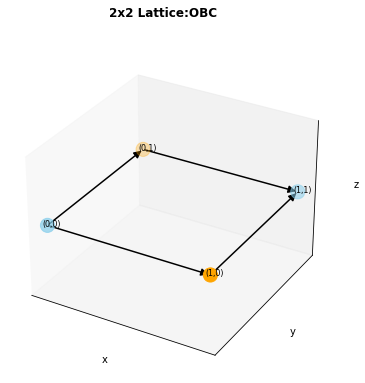

In [7]:
latt.draw_graph_func(gauss_law_fig=False)#,savefig_dir='.')

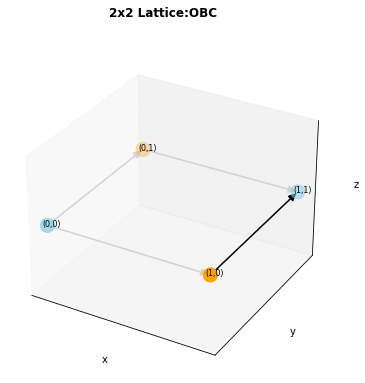

In [8]:
#only dynamical fields after Gauss law applied
latt.draw_graph_func(gauss_law_fig=True,e_op_free=class_H.e_op_free)#,savefig_dir='.')

In [9]:
len(class_H.e_op_free)

1

In [10]:
Hamiltonian_Pauli_tot = class_H.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_b_op,lambd=lambd)

In [11]:
print('is hermitian:',Hamiltonian_Pauli_tot.is_hermitian())

spectrum, eigenvectors_matrix = eigsh(Hamiltonian_Pauli_tot.to_spmatrix(),k=num_eigs,which="SA",ncv = 50)#

idx = spectrum.argsort() 
spectrum = spectrum[idx]
eigenvectors_matrix = eigenvectors_matrix[:,idx]
print(f'Spectrum of H with pbc{pbc}_g{g}_l{l}_factE{fact_e_op}_factB{fact_b_op}_m{m}_Omega{omega}_TN{tn_comparison}')


for kk,evalu in enumerate(spectrum):
        if evalu<900:# only physical states, 1000 corresponds to factor of penalty term
                print(f'E_{kk}=',round(evalu,8))
                
                         

is hermitian: True
Spectrum of H with pbcFalse_g1_l1_factE1_factB1_m7_Omega1_TNFalse
E_0= -14.29268012
E_1= -12.06130724
E_2= -11.83683911
E_3= 0.2202931
E_4= 0.22719615


In [12]:
#plaquette
print('plaq.',(Statevector(np.array(eigenvectors_matrix[:,0])).expectation_value(class_H.hamiltonian_mag_pauli).real)/len(latt.plaq_list))


plaq. 0.40703152004125465
